In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt

np.random.seed(100)
LEVEL = 'level_1'

In [2]:
class SigmoidNeuron:
    def __init__(self):
        self.w = None
        self.b = None
    
    def perceptron(self, x):
        return np.dot(x, self.w.T) + self.b
  
    def sigmoid(self, x):
        return 1.0/(1.0 + np.exp(-x))
  
    def grad_w_mse(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred) * x
  
    def grad_b_mse(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred)
  
    def grad_w_ce(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        if y == 0:
            return y_pred * x
        elif y == 1:
            return -1 * (1 - y_pred) * x
        else:
            raise ValueError("y should be 0 or 1")
    
    def grad_b_ce(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        if y == 0:
            return y_pred 
        elif y == 1:
            return -1 * (1 - y_pred)
        else:
            raise ValueError("y should be 0 or 1")
  
    def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
       # initialise w, b
        if initialise:
            self.w = np.random.randn(1, X.shape[1])
            self.b = 0
      
        if display_loss:
            loss = {}
    
        for i in tqdm(range(epochs), total=epochs, unit="epoch"):
            dw = 0
            db = 0
            for x, y in zip(X, Y):
                if loss_fn == "mse":
                    dw += self.grad_w_mse(x, y)
                    db += self.grad_b_mse(x, y) 
                elif loss_fn == "ce":
                    dw += self.grad_w_ce(x, y)
                    db += self.grad_b_ce(x, y)
            self.w -= learning_rate * dw
            self.b -= learning_rate * db
      
            if display_loss:
                Y_pred = self.sigmoid(self.perceptron(X))
                if loss_fn == "mse":
                    loss[i] = mean_squared_error(Y, Y_pred)
                elif loss_fn == "ce":
                    loss[i] = log_loss(Y, Y_pred)
    
        if display_loss:
            plt.plot(np.array(list(loss.values())).astype(float))
            plt.xlabel('Epochs')
            if loss_fn == "mse":
                plt.ylabel('Mean Squared Error')
            elif loss_fn == "ce":
                plt.ylabel('Log Loss')
            plt.show()
      
    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.sigmoid(self.perceptron(x))
            Y_pred.append(y_pred)
        return np.array(Y_pred)

In [3]:
def read_all(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    files = os.listdir(folder_path)
    for i, file_name in tqdm(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = Image.open(file_path)
        image = image.convert("L")
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images

In [4]:
languages = ['ta', 'hi', 'en']
#trainPath = "../input/padhai-text-non-text-classification-level-1/"+LEVEL+"_train/"+LEVEL+"/"
#testPath = "../input/padhai-text-non-text-classification-level-1/"+LEVEL+"_test/kaggle_"+LEVEL
images_train = read_all("../input/text-non-text-classification/level_3_train/level_3/"+"background", key_prefix='bgr_') # change the path
for language in languages:
    images_train.update(read_all("../input/text-non-text-classification/level_3_train/level_3/"+language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all("../input/text-non-text-classification/level_3_test/kaggle_level_3", key_prefix='') # change the path
print(len(images_test))

  1%|          | 49/4500 [00:00<00:09, 484.40it/s]

Reading:


  4%|▎         | 55/1500 [00:00<00:02, 549.28it/s]

Reading:


  4%|▍         | 61/1500 [00:00<00:02, 603.76it/s]

Reading:


  4%|▍         | 66/1500 [00:00<00:02, 657.43it/s]

Reading:


  2%|▏         | 55/3000 [00:00<00:05, 546.99it/s]

9000
Reading:


100%|██████████| 3000/3000 [00:04<00:00, 659.57it/s]

3000


In [5]:
! cd ../input

In [6]:
list(images_test.keys())[:5]

['2345', '170', '1879', '438', '2257']

In [7]:
X_train = []
Y_train = []

for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
    ID_test.append(int(key))
    X_test.append(value)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(9000, 4096) (9000,)
(3000, 4096)


In [8]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

# Perceptron

In [9]:
class Perceptron:
    def __init__(self):
        self.w = None
        self.b = None 
    def model(self,x):
        return 1 if (np.dot(self.w,x) >= self.b) else 0 
    def predict(self,X):
        Y=[]
        for x in X:
            result = self.model(x)
            Y.append(result)
        return np.array(Y) 
    def fit(self,X,Y,epochs,lr):
        self.w = np.ones(X.shape[1])
        self.b = 0
        accuracy = {}
        max_accuracy = 0
        w_matrix = []
        b_matrix = []
        for i in range(epochs):
            for x,y in zip(X,Y):
                y_pred = self.model(x)
                if y==1 and y_pred==0:
                    self.w = self.w + lr*x
                    self.b = self.b + lr*1
                elif y==0 and y_pred==1:
                    self.w = self.w - lr*x
                    self.b = self.b - lr*1
            w_matrix.append(self.w)
            b_matrix.append(self.b)
            accuracy[i] = accuracy_score(self.predict(X),Y)
            if (accuracy[i]>max_accuracy):
                max_accuracy = accuracy[i]
                chkptw = self.w
                chkptb = self.b
        self.w = chkptw
        self.b = chkptb
        print(max_accuracy)
        plt.plot(*zip(*sorted(accuracy.items())))
        plt.ylim([0,1])
        plt.show()
        w_matrix = np.array(w_matrix)
        b_matrix = np.array(b_matrix)
        return w_matrix,b_matrix

In [10]:
perceptron = Perceptron()

0.7888888888888889


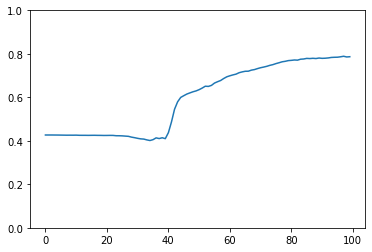

In [11]:
w_matrix,b_matrix = perceptron.fit(X_scaled_train,Y_train,100,0.000013)

In [12]:
Y_pred_train = perceptron.predict(X_scaled_train)
print(accuracy_score(Y_pred_train,Y_train))

0.7888888888888889


In [13]:
Y_pred_test = perceptron.predict(X_scaled_test)

In [14]:
print(Y_pred_test)

[1 0 0 ... 1 1 1]


# """""""

100%|██████████| 100/100 [00:57<00:00,  1.74epoch/s]


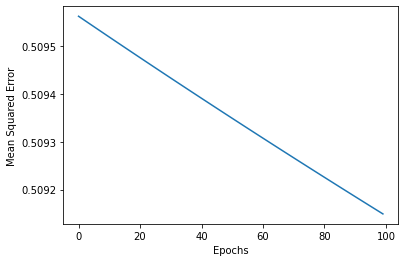

In [15]:
sn_mse = SigmoidNeuron()
sn_mse.fit(X_scaled_train, Y_train, epochs=100, learning_rate=0.0000009, loss_fn="mse", display_loss=True)

100%|██████████| 100/100 [00:49<00:00,  2.04epoch/s]


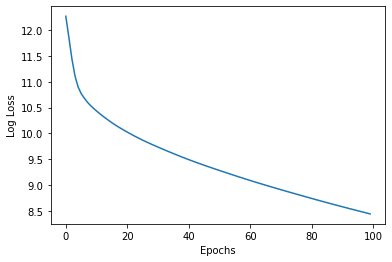

In [16]:
sn_ce = SigmoidNeuron()
sn_ce.fit(X_scaled_train, Y_train, epochs=100, learning_rate=0.000005, loss_fn="ce", display_loss=True)

In [17]:
def print_accuracy(sn):
    Y_pred_train = sn.predict(X_scaled_train)
    Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
    accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
    print("Train Accuracy : ", accuracy_train)
    print("-"*50)

In [18]:
print_accuracy(sn_mse)
#print_accuracy(sn_ce)

Train Accuracy :  0.48477777777777775
--------------------------------------------------


## Sample Submission

In [19]:
#Y_pred_test = sn_ce.predict(X_scaled_test)
#Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()
submission = {}
submission['ImageId'] = ID_test
submission['Class'] = Y_pred_test

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submission.csv", index=False)

In [20]:
print(submission)

      ImageId  Class
2757        0      1
1796        1      1
741         2      0
2261        3      1
2583        4      0
...       ...    ...
134      2995      1
1032     2996      0
1102     2997      0
302      2998      0
2497     2999      1

[3000 rows x 2 columns]
